# Localization: 
#### This notebook localizes objects in the base VGG16 model

In [1]:
###### Base Imports ######
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import cv2
import glob

###### Base Models ######
from keras.applications import VGG16
from keras.models import Model

###### Keras Methods #####
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers import Dense,GlobalAveragePooling2D
from keras.engine import InputLayer

import keras

###### Local Imports #####
from get_data import loadimgs

####### Supporter #####
from seaborn import heatmap #Dispaly heatmaps

Using TensorFlow backend.


### Global objects

In [2]:
IMAGE_SIZE = 224

In [3]:
EPSILON = 0.02

### Load Model

In [4]:
base_model=VGG16(weights='imagenet',include_top=False) #imports the VGG model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(3,activation='softmax')(x) #final layer with sigmoid activation

In [5]:

model=Model(inputs=base_model.input,outputs=preds)
model.load_weights("output_transf_muliclass/new_dataset_model/new_final.h5")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

### Function Definitions

In [6]:
def to_fully_conv(model):
    """
    This function converts fully connencted layers into convolutional layers for localization.
    Modified from the following:
    https://stackoverflow.com/questions/41161021/how-to-convert-a-dense-layer-to-an-equivalent-convolutional-layer-in-keras
    """
    new_model = Sequential()

    #input_layer = InputLayer(input_shape=(None, None, 3), name="input_new")

    #new_model.add(input_layer)

    for layer in model.layers:
        print(layer)
        if "GlobalAveragePooling2D" in str(layer):
            flattened_ipt = True
            f_dim = layer.input_shape

        elif "Dense" in str(layer):

            input_shape = layer.input_shape
            output_dim =  layer.get_weights()[1].shape[0]
            W,b = layer.get_weights()

            if flattened_ipt:
                shape = (f_dim[1],f_dim[2],f_dim[3],output_dim)
                new_W = W.reshape(shape)
                new_layer = Convolution2D(output_dim,
                                          (f_dim[1],f_dim[2]),
                                          strides=(1,1),
                                          activation=layer.activation,
                                          padding='valid',
                                          weights=[new_W,b])
                flattened_ipt = False

            else:
                shape = (1,1,input_shape[1],output_dim)
                new_W = W.reshape(shape)
                new_layer = Convolution2D(output_dim,
                                          (1,1),
                                          strides=(1,1),
                                          activation=layer.activation,
                                          padding='valid',
                                          weights=[new_W,b])
        else:
            new_layer = layer
            
        new_model.add(new_layer)
        flattened_ipt = False
    return new_model

In [7]:
def process_pred_img(img, w = 224, h = 224):
    """
    This function resizes and reshapes an input image for processing
    """
    img = cv2.resize(img,(h,w))
    img = img.reshape(1,w,h,3)
    return(img)

In [8]:
new_model = to_fully_conv(model)

# Example Image

In [9]:
example_not_stocked = "data/train/Not_Stocked/not_stocked_0_2371.jpeg"

In [10]:
example_stocked = "data/train/Stocked/stocked_0_2085.jpeg"

In [11]:
img_not_stocked = cv2.imread(example_not_stocked)
img_not_stocked = cv2.cvtColor(img_not_stocked, cv2.COLOR_BGR2RGB)

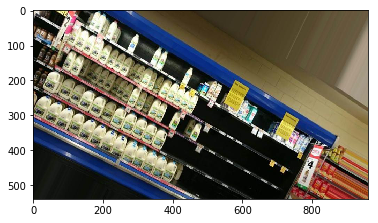

In [12]:
plt.imshow(img_not_stocked)

In [13]:
h,w = 224,224
img_not_stocked = cv2.resize(img_not_stocked,(h,w))

In [14]:
im_ns = process_pred_img(img_not_stocked)

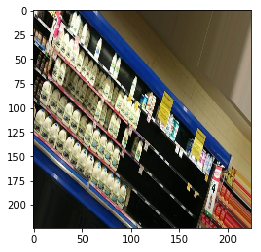

In [15]:
plt.imshow(im_ns[0]) #After resize and reshape


In [16]:
x = process_pred_img(img_not_stocked, w = 300, h=300) #Example heatmap of above
ns = new_model.predict(np.array(x))

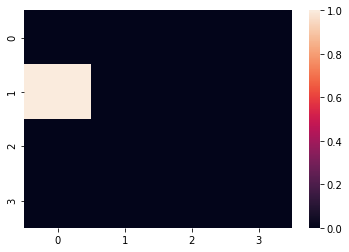

In [17]:
heatmap(ns[0,:,:,0])

In [18]:
ns[0,:,:,0]

array([[1.1379368e-27, 0.0000000e+00, 0.0000000e+00, 5.7912293e-36],
       [1.0000000e+00, 1.5116638e-13, 1.5664711e-31, 2.9562929e-05],
       [0.0000000e+00, 9.1377420e-31, 8.0713019e-36, 1.3904101e-35],
       [0.0000000e+00, 8.3806223e-32, 0.0000000e+00, 7.3036151e-29]],
      dtype=float32)

In [20]:
filename = "data/train/Not_Stocked/not_stocked_0_2371.jpeg"
unscaled = cv2.imread(filename)
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE))
feat_scaled = process_pred_img(image, w = 500, h=500)

region = np.squeeze(new_model.predict(feat_scaled))
output = np.zeros(region[:,:,0].shape, dtype=np.uint8)
output[region[:,:,0] > 0.5] = 1

In [21]:
_,contours, _ = cv2.findContours(output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    approx = cv2.approxPolyDP(cnt, EPSILON * cv2.arcLength(cnt, True), True)
    x, y, w, h = cv2.boundingRect(approx)

    x0 = np.rint(x * unscaled.shape[1] / output.shape[1]).astype(int)
    x1 = np.rint((x + w) * unscaled.shape[1] / output.shape[1]).astype(int)
    y0 = np.rint(y * unscaled.shape[0] / output.shape[0]).astype(int)
    y1 = np.rint((y + h) * unscaled.shape[0] / output.shape[0]).astype(int)
    cv2.rectangle(unscaled, (x0, y0), (x1, y1), (255, 0, 255), 10)

True

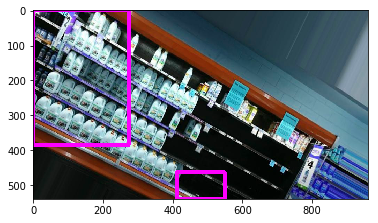

In [22]:
plt.imshow(unscaled)
cv2.imwrite("localized.jpeg",unscaled)

In [23]:
x0,x1,y0,y1

(0, 274, 0, 386)

In [24]:
IMAGE_SIZE

224

### Localize Function, input file path, model, output localization

In [25]:

def localizee(model,filepath = "", W = 300, H = 300, less = True):
    """
    This function iterates through scales for a fixed w, h image and gets a heatmap. 
    The function return a list of bounding over the scales.
    It thresholds the heatmap at .7, and appends to a list.
    This function follows from: https://github.com/lars76/object-localization/blob/master/example_3/test.py
    """
    scales = np.arange(0.3,1.1, 0.1) #[0.3, 0.4,..., 0.9, 1.0]
    list_of_heatmaps = []

    THRESHOLD = .5
    IMAGE_SIZE = 224
    unscaled = cv2.imread(filepath)
    
    bounding_boxes = [] #return list of bounding boxes w/ corrosponding scale
    if unscaled is None:
        #No image found
        print("No such image: " + filepath)
        return
    image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) #(300,300)
    for i,scale in enumerate(scales[::-1]):
        #Scale the image
        image_copy = image.copy() 
        unscaled_copy = unscaled.copy()
        feat_scaled = process_pred_img(image_copy, w = int(W*scale), h= int(H*scale) )

        region = np.squeeze(model.predict(feat_scaled))
        output = np.zeros(region[:,:,0].shape, dtype=np.uint8)
        if less:
            output[region[:,:,0] < THRESHOLD] = 1 
            output[region[:,:,0] >= THRESHOLD] = 0
        else:
            output[region[:,:,0] > THRESHOLD] = 1 
            output[region[:,:,0] <= THRESHOLD] = 0
            
        _,contours, _ = cv2.findContours(output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        for cnt in contours:
            approx = cv2.approxPolyDP(cnt, EPSILON * cv2.arcLength(cnt, True), True)
            x, y, w, h = cv2.boundingRect(approx)
            try:
                #Sometimes output is a scalar and has no shape
                x0 = np.rint(x * unscaled.shape[1] / output.shape[1]).astype(int)
                x1 = np.rint((x + w) * unscaled.shape[1] / output.shape[1]).astype(int)
                y0 = np.rint(y * unscaled.shape[0] / output.shape[0]).astype(int)
                y1 = np.rint((y + h) * unscaled.shape[0] / output.shape[0]).astype(int)
            except Exception as e:
                continue
            
            bounding_boxes.append((x0, y0, x1, y1))
            cv2.rectangle(unscaled_copy, (x0, y0), (x1, y1), (255, 0, 255), 10)
        cv2.imwrite("localized_sample/localized_INDEX_" + str(i) + "_FILE_" + filepath.split("/")[-1], unscaled_copy)

    return np.array(bounding_boxes)


In [42]:
filename2 = "data2/test/train_2.png"


In [49]:
import time

start = time.time()
localized = localizee(model=new_model, 
         filepath = filename2,
         W = 1000, 
         H = 1000)



localized2 = localizee(model=new_model, 
         filepath = filename2,
         W = 1000, 
         H = 1000, 
        less = False)
end = time.time()
print((end - start)/60)


21.234607716401417


## Non Maximum suppression

In [50]:
# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
 
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    # initialize the list of picked indexes	
    pick = []
 
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
 
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
 
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
 
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
 
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
 
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
 
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

In [51]:
suppressed_boxes = non_max_suppression_fast(boxes = localized, overlapThresh = .3)
suppressed_boxes2 = non_max_suppression_fast(boxes = localized2, overlapThresh = .5)

In [52]:
suppressed_boxes, suppressed_boxes2

(array([[ 673, 1080, 1010, 1200],
        [   0, 1067,  249, 1200],
        [   0,    0, 1122, 1200]]), array([[   0,    0, 1122, 1200]]))

True

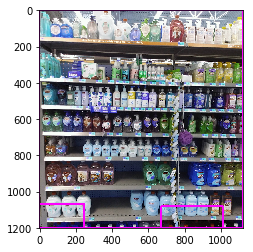

In [53]:
img = cv2.imread(filename2, cv2.COLOR_BGR2RGB)
for box in suppressed_boxes:
    cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (255, 0, 255), 10)
plt.imshow(img)
cv2.imwrite("test.jpeg", img)

True

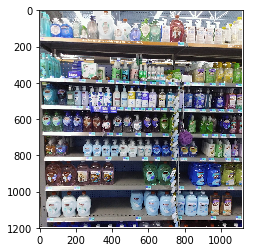

In [54]:
img = cv2.imread(filename2, cv2.COLOR_BGR2RGB)
for box in suppressed_boxes2:
    cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (255, 255, 255), 10)
plt.imshow(img)
cv2.imwrite("test2.jpeg", img)